# Where's the Tweeter? Identifying Tweeters from Tweets

In [1]:
import pandas as pd
import numpy as np
import ast, re, time
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

%matplotlib inline

In [2]:
# download the stopwords corpus from NLTK
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Tuohuang\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [3]:
datafolder = "data/"

In [4]:
class DataReader:
    def __init__(self, flag):
        self.flag = flag
        if self.flag == "count":
            self.traindata = datafolder + "train_count.csv"
            self.testdata = datafolder + "test_count.csv"
            self.devdata = datafolder + "dev_count.csv"
        elif self.flag == "tfidf":
            self.traindata = datafolder + "train_tfidf.csv"
            self.testdata = datafolder + "test_tfidf.csv"
            self.devdata = datafolder + "dev_tfidf.csv"
        elif self.flag == "glove":
            self.traindata = datafolder + "train_glove300.csv"
            self.testdata = datafolder + "test_glove300.csv"
            self.devdata = datafolder + "dev_glove300.csv"
        else:
            self.traindata = datafolder + "train_full.csv"
            self.testdata = datafolder + "test_full.csv"
            self.devdata = datafolder + "dev_full.csv"

        self.label_mapper = {'SOUTH': 0, 
                             'MIDWEST': 1, 
                             'NORTHEAST': 2, 
                             'WEST': 3}
        self.reverse_label_mapper = {0: 'SOUTH', 
                                     1: 'MIDWEST', 
                                     2: 'NORTHEAST', 
                                     3: 'WEST'}
    
    def read_files(self):
        train = pd.read_csv(self.traindata)
        test = pd.read_csv(self.testdata)
        dev = pd.read_csv(self.devdata)
        train.dropna()
        test.dropna()
        dev.dropna()
        return (train, test, dev)
    
    def reformat_features(self, unformatted_fts):
        unformatted_fts = ast.literal_eval(unformatted_fts)
        formatted_fts = [x[1] for x in unformatted_fts]
        return formatted_fts
    
    def reformat_glove_fts(self, unformatted_fts):
        return list(ast.literal_eval(','.join(unformatted_fts.split(' '))))
        
    def get_longest_tweet(self, lst):
        list_len = [len(i) for i in lst]
        return max(list_len)

    def map_labels(self, label):
        return self.label_mapper[label]

    def prepare_features(self, train, test, dev):
        if self.flag == "count" or self.flag == "tfidf":
            # prepare the train data
            train_fts = train['tweet'].apply(self.reformat_features).to_list()
            max_len = self.get_longest_tweet(train_fts)
            train_arr = []
            for ix in train_fts:
                train_arr.append(ix + [0] * (max_len - len(ix)))
            train_arr = np.array(train_arr)
            print("[INFO] X Train Shape: ", train_arr.shape)

            # prepare the dev data
            dev_fts = dev['tweet'].apply(self.reformat_features).to_list()
            dev_arr = []
            for ix in dev_fts:
                dev_arr.append(ix + [0] * (max_len - len(ix)))
            dev_arr = np.array(dev_arr)
            print("[INFO] X Dev Shape: ", dev_arr.shape)

            # prepare the test data
            test_fts = test['tweet'].apply(self.reformat_features).to_list()
            test_arr = []
            for ix in test_fts:
                test_arr.append(ix + [0] * (max_len - len(ix)))
            test_arr = np.array(test_arr)
            print("[INFO] X Test Shape: ", test_arr.shape)

        elif self.flag == "glove":
            # prepare the train data.
            train_fts = train['tweet'].apply(self.reformat_glove_fts).to_list()
            train_arr = np.array(train_fts)
            print("[INFO] X Train Shape: ", train_arr.shape)

            # prepare the dev data.
            dev_fts = dev['tweet'].apply(self.reformat_glove_fts).to_list()
            dev_arr = np.array(dev_fts)
            print("[INFO] X Dev Shape: ", dev_arr.shape)

            # prepare the test data.
            test_fts = test['tweet'].apply(self.reformat_glove_fts).to_list()
            test_arr = np.array(test_fts)
            print("[INFO] X Test Shape: ", test_arr.shape)
        
        else:
            # prepare the train data.
            train_fts = train['tweet'].values
            processed_tweets = []
            for tweet in range(0, len(train_fts)):
                processed_tweet = ' '.join([x for x in train_fts[tweet].split(' ') if '@' not in x])
                processed_tweet = re.sub(r'\W', ' ', processed_tweet)
                processed_tweet = re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_tweet)
                processed_tweet = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_tweet) 
                processed_tweet= re.sub(r'\s+', ' ', processed_tweet, flags=re.I)
                processed_tweet = processed_tweet.lower()
                processed_tweets.append(processed_tweet)
            
            tfidf = TfidfVectorizer(max_features=6000, stop_words=stopwords.words('english'))  
            train_arr = tfidf.fit_transform(processed_tweets).toarray()
            print("[INFO] X Train Shape: ", train_arr.shape)

            # prepare the dev data.
            dev_fts = dev['tweet'].values
            processed_tweets = []
            for tweet in range(0, len(dev_fts)):
                processed_tweet = ' '.join([x for x in dev_fts[tweet].split(' ') if '@' not in x])
                processed_tweet = re.sub(r'\W', ' ', processed_tweet)
                processed_tweet = re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_tweet)
                processed_tweet = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_tweet)
                processed_tweet= re.sub(r'\s+', ' ', processed_tweet, flags=re.I)
                processed_tweet = processed_tweet.lower()
                processed_tweets.append(processed_tweet)
            
            tfidf = TfidfVectorizer(max_features=6000, stop_words=stopwords.words('english'))  
            dev_arr = tfidf.fit_transform(processed_tweets).toarray()
            print("[INFO] X Dev Shape: ", dev_arr.shape)

            # prepare the test data.
            test_fts = test['tweet'].values
            processed_tweets = []
            for tweet in range(0, len(test_fts)):
                processed_tweet = ' '.join([x for x in test_fts[tweet].split(' ') if '@' not in x])
                processed_tweet = re.sub(r'\W', ' ', processed_tweet)
                processed_tweet = re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_tweet)
                processed_tweet = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_tweet) 
                processed_tweet= re.sub(r'\s+', ' ', processed_tweet, flags=re.I)
                processed_tweet = processed_tweet.lower()
                processed_tweets.append(processed_tweet)
            
            tfidf = TfidfVectorizer(max_features=6000, stop_words=stopwords.words('english'))  
            test_arr = tfidf.fit_transform(processed_tweets).toarray()
            print("[INFO] X Test Shape: ", test_arr.shape)

        return (train_arr, test_arr, dev_arr)
                        
    def prepare_labels(self, train, dev):
        # prepare the train data
        train_lbls = np.array(train['region'].apply(self.map_labels).tolist())
        print("[INFO] y Train Shape: ", train_lbls.shape)

        # prepare the dev data
        dev_lbls = np.array(dev['region'].apply(self.map_labels).tolist())
        print("[INFO] y Dev Shape: ", dev_lbls.shape)

        return (train_lbls, dev_lbls)
    
    def count_tweets_on_location(self, train_lbls, dev_lbls):
        train_count = dict(sorted(Counter(list(train_lbls)).items()))
        dev_count = dict(sorted(Counter(list(dev_lbls)).items()))
        
        # plot
        sns.set(rc={'text.usetex': True})
        ax = plt.subplot(111)
        plt.bar(range(len(train_count)), list(train_count.values()), tick_label=list(self.label_mapper.keys()), color='b', label='Train')
        plt.bar(range(len(dev_count)), list(dev_count.values()), tick_label=list(self.label_mapper.keys()), color='r', label='Dev')

        plt.legend()
        plt.ylabel("Tweet Count")
        plt.xlabel("Location")
        plt.savefig('count.png', dpi=500)
        
    def load_to_numpy(self):
        train, test, dev = self.read_files()
        train_fts, test_fts, dev_fts = self.prepare_features(train, test, dev)
        train_lbls, dev_lbls = self.prepare_labels(train, dev)

        return (train_fts, train_lbls, dev_fts, dev_lbls, test_fts)

In [5]:
class Trainer:
    def __init__(self, flag):
        self.dataflag = flag
        self.dr = DataReader(self.dataflag)
        self.labels = self.dr.label_mapper # get the labels
        self.classifiers = {"RandomForest": RandomForestClassifier(),
                            "DecisionTree": DecisionTreeClassifier(random_state=0),
                            "MLP": MLPClassifier(random_state=1, max_iter=300)}
    
    def fit_classifier(self, clf, X, y):
        return clf.fit(X, y)
    
    def classifier_predict(self, clf, X):
        return clf.predict(X)

    def get_data(self):
        train_fts, train_lbls, dev_fts, dev_lbls, test_fts = self.dr.load_to_numpy()
        return train_fts, train_lbls, dev_fts, dev_lbls, test_fts
    
    def get_accuracy(self, y_true, y_pred):
        return accuracy_score(y_true, y_pred)
    
    def print_classification_report(self, y_true, y_pred, labels):
        print(classification_report(y_true, y_pred, target_names=labels, zero_division=0))

    def main(self):
        print(f"[INFO] Training for data type {self.dataflag}")
        train_fts, train_lbls, dev_fts, dev_lbls, test_fts = self.get_data()
        #self.dr.count_tweets_on_location(train_lbls, dev_lbls)
        # applying LDA on the data to reduce the dimension.
        lda = LDA(n_components=3)
        train_fts = lda.fit_transform(train_fts, train_lbls)
        dev_fts = lda.fit_transform(dev_fts, dev_lbls)
        test_fts = lda.transform(test_fts)

        for clftype, clf in self.classifiers.items():
            start = time.time()
            fitted_clf = self.fit_classifier(clf, train_fts, train_lbls)
            
            y_pred = self.classifier_predict(fitted_clf, dev_fts)
            test_y_pred = self.classifier_predict(fitted_clf, test_fts)
            mapped_preds = [self.dr.reverse_label_mapper[x] for x in test_y_pred]
            # write the predictions to file.
            to_write = open(clftype + f"_{self.dataflag}_preds.csv", "w+")
            to_write.write('Predictions' + '\n')
            for p in mapped_preds:
                to_write.write(p + '\n')
            to_write.close()
            # get accuracy
            accuracy = self.get_accuracy(dev_lbls, y_pred)
            print(f"[INFO] Dev Data Accuracy with Classifier {clftype} is {accuracy}")
            self.print_classification_report(dev_lbls, y_pred, list(self.labels.keys()))
            end = time.time()
            print(f"[INFO] Trained classifier {clftype} in {end-start}")

In [6]:
# different types of feature extractors
opts = ["count", "tfidf", "custom-tfidf", "glove"]

for dataopt in opts:
    trainer = Trainer(dataopt)
    trainer.main()

[INFO] Training for data type count
[INFO] X Train Shape:  (133795, 28)
[INFO] X Dev Shape:  (11475, 28)
[INFO] X Test Shape:  (12018, 28)
[INFO] y Train Shape:  (133795,)
[INFO] y Dev Shape:  (11475,)
[INFO] Dev Data Accuracy with Classifier RandomForest is 0.35564270152505445
              precision    recall  f1-score   support

       SOUTH       0.38      0.46      0.42      4266
     MIDWEST       0.08      0.05      0.06      1484
   NORTHEAST       0.38      0.47      0.42      4295
        WEST       0.11      0.01      0.02      1430

    accuracy                           0.36     11475
   macro avg       0.24      0.25      0.23     11475
weighted avg       0.31      0.36      0.32     11475

[INFO] Trained classifier RandomForest in 8.796972036361694
[INFO] Dev Data Accuracy with Classifier DecisionTree is 0.349281045751634
              precision    recall  f1-score   support

       SOUTH       0.38      0.41      0.39      4266
     MIDWEST       0.14      0.08      0.1

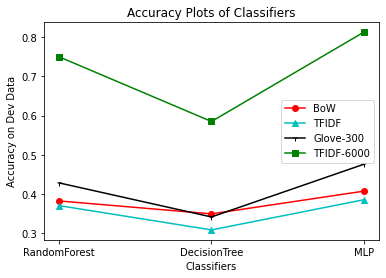

In [15]:
#sns.set(rc={'text.usetex': True})

labels = ["RandomForest", "DecisionTree", "MLP"]

count = [0.382, 0.349, 0.407]
tfidf = [0.37, 0.308, 0.385]
custom_tfidf = [0.75, 0.585, 0.813]
glove = [0.428, 0.3411, 0.4756]

plt.plot(labels, count, marker='o', color='r', label='BoW')
plt.plot(labels, tfidf, marker='^', color='c', label='TFIDF')
plt.plot(labels, glove, marker='1', color='k', label='Glove-300')
plt.plot(labels, custom_tfidf, marker='s', color='g', label='TFIDF-6000')
plt.legend()
plt.ylabel('Accuracy on Dev Data')
plt.xlabel('Classifiers')
plt.title('Accuracy Plots of Classifiers')
plt.savefig("acc_scores.png", dpi=500)